# **Taller 3** B

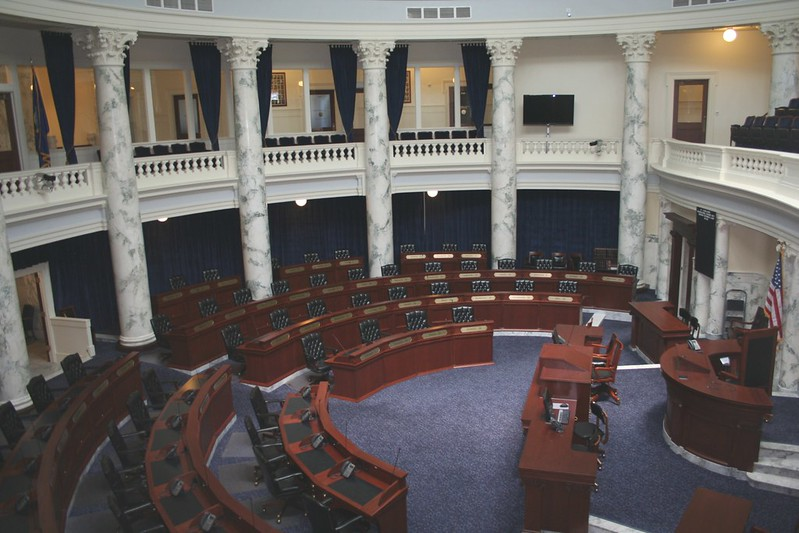

# Links Útiles


[Intuición sobre regresión lineal](https://www.youtube.com/watch?v=nk2CQITm_eo&list=PLblh5JKOoLUIzaEkCLIUxQFjPIlapw8nU&index=2&ab_channel=StatQuestwithJoshStarmer)

[Significancia de la regresión lineal](https://www.statology.org/a-simple-guide-to-understanding-the-f-test-of-overall-significance-in-regression/#:~:text=The%20F,has%20the%20following%20two%20hypotheses)

[Supuestos regresión lineal simple](https://online.stat.psu.edu/stat500/lesson/9/9.2/9.2.3)

[Supuestos de regresión lineal extra I](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)


[Supuestos de regresión lineal extra II](https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression)

# Introducción


Como equipo se encuentran en el grupo de asesores para el ministerio de la mujer y equidad de género de un gobierno ficticio sobre una población ficticia. Se les da la tarea de, a partir de un dataset, analizar la realidad país respecto a la remuneración laboral, el nivel de educación y la igualdad de género.

# Datos & Libs

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t
from scipy.stats import f as fisher
from sklearn.linear_model import LinearRegression

In [81]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQ3p-2Nck8Y0ALjngIdquzJjF_ryIvU3brk18owc2WidOODHaAPL5revcfceeZ6bgIi-rjtPKjIsW9i/pub?gid=1189476887&single=true&output=csv")
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [82]:
df.dropna(inplace=True)

In [83]:
df['Education Level'] = df['Education Level'].apply(lambda x: "Bachelor's Degree" if "bachelor" in x.lower()
                                                    else "Master's Degree" if "master" in x.lower()
                                                    else "PhD" if "phd" in x.lower() or "ph.d" in x.lower()
                                                    else x)

In [84]:
replacements = {
    'Director of Marketing': 'Marketing Director',
    'Customer Service Rep': 'Customer Service Representative',
    'Human Resources Manager': 'HR Manager',
    'Front end Developer': 'Front-End Developer',
    'Front End Developer': 'Front-End Developer',
    'Human Resources Coordinator': 'HR Coordinator',
    'Juniour HR Coordinator': 'Junior HR Coordinator',
    'Junior HR Coordinator': 'Junior HR Coordinator',
    'Director of Sales': 'Sales Director'
}

df['Job Title'] = df['Job Title'].replace(replacements)

# Funciones

### Intervalos de confianza

In [85]:
def IC_media(n, media_muestral, std_muestral, alpha=0.05):
    return t.interval(1-alpha, df=n-1, loc=media_muestral, scale=std_muestral/np.sqrt(n))

def IC_prop(n1,frac1,alpha=0.05):
  std_err = np.sqrt((frac1*(1.0-frac1)/n1))
  z_alpha = norm.ppf(1-alpha/2.0)
  IC_inf = frac1 - z_alpha * std_err
  IC_sup = frac1 + z_alpha * std_err
  return (IC_inf,IC_sup)

#para media1-media2
def IC_dos_medias_hetero(muestra1, muestra2, alpha=0.05):
  n1 = len(muestra1); n2 = len(muestra2);
  media1 = np.mean(muestra1); media2 = np.mean(muestra2);
  std1 = np.std(muestra1,ddof=1); std2 = np.std(muestra2,ddof=1);
  gl_num = (std1**2/float(n1) + std2**2/float(n2))**2
  gl_den = ((std1**2/float(n1))**2)/(n1-1.0) + ((std2**2/float(n2))**2)/(n2-1.0)
  gl = int(np.floor(gl_num/gl_den))
  t_alpha = t.ppf(1-alpha/2.0,df=gl)
  std_error = np.sqrt(std1**2/n1 + std2**2/n2)
  IC_inf = (media1-media2) - t_alpha * std_error
  IC_sup = (media1-media2) + t_alpha * std_error
  return IC_inf,IC_sup

#para prop1-prop2
def IC_dos_props(n1,n2,frac1,frac2, alpha=0.05):
  std_err = np.sqrt((frac1*(1.0-frac1)/n1) + (frac2*(1.0-frac2)/n2))
  z_alpha = norm.ppf(1-alpha/2.0)
  IC_inf = (frac1-frac2) - z_alpha * std_err
  IC_sup = (frac1-frac2) + z_alpha * std_err
  return IC_inf,IC_sup

### Test de Hipotesis

In [86]:
#H0: mu1 = mu0 (mu1 desconocida, m0 valor fijo, sigma desconocida)
def contraste_1media(n1,media1,std1,mu0,error_tipo1,alternativa='1>0'):
  region_critica = []
  gl = n1-1
  std_error = np.sqrt(std1**2/n1)
  T0 = (media1-mu0)/std_error#estadistico bajo H0
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value


#H0: mu_x = mu_y (mu_x,mu_y ambas no conocidas, sigma diferente y desconocido)
def contraste_2medias(n_x,n_y,media_x,media_y,std_x,std_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  gl_num = (std_x**2/float(n_x) + std_y**2/float(n_y))**2
  gl_den = ((std_x**2/float(n_x))**2)/(n_x-1.0) + ((std_y**2/float(n_y))**2)/(n_y-1.0)
  print(gl_den)
  gl = int(np.floor(gl_num/gl_den))
  std_error = np.sqrt(std_x**2/n_x + std_y**2/n_y)
  T0 = (media_x-media_y)/std_error#estadistico bajo H0
  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value

#H0: sigma1 = sigma2 (sigma1,sigma2 ambas no conocidas)
def contraste_dos_varianzas(n_x,n_y,std_x,std_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  F0 = std_x**2/std_y**2
  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1,dfn=n_x-1, dfd=n_y-1), right=np.inf,closed='neither'))
    p_value = 1-fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=fisher.ppf(error_tipo1,dfn=n_x-1, dfd=n_y-1),closed='neither'))
    p_value = fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=fisher.ppf(error_tipo1/2,dfn=n_x-1, dfd=n_y-1),closed='neither'))
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1/2,dfn=n_x-1, dfd=n_y-1),right=np.inf,closed='neither'))
    p_value = 2*min(1-fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1),fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1))
  return F0, region_critica, p_value

#H0: p1 = p0 (p1 desconocida, p0 valor fijo)
def contraste_1prop(n1,prop1,p0,error_tipo1,alternativa='1>0'):
  region_critica = []
  std_error = np.sqrt(p0*(1.0-p0))*np.sqrt(1.0/n1)
  Z0 = (prop1-p0)/std_error
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value

#H0: p1 = p2 (p1,p2 no conocidas, ni funcion una de la otra)
def contraste_2props(n_x,n_y,prop_x,prop_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  prop_comb = (n_x*prop_x + n_y*prop_y)/(n_x+n_y)
  std_error = np.sqrt(prop_comb*(1.0-prop_comb))*np.sqrt(1.0/n_x + 1.0/n_y)
  Z0 = (prop_x-prop_y)/std_error

  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value

### Regresión lineal

In [87]:
def p_value_analysis(X, y, reg, alpha):

    y_pred = reg.predict(X)
    SS_fit = np.sum((y - y_pred) ** 2)

    y_mean = np.mean(y)
    SS_y_mean = np.sum((y_mean - y) ** 2)

    # grados de libertad, en este caso: cantidad de weights + bias (edad y bias) - cantidad de variables a predecir (salario)
    # bias y salario se cancelan, por lo cual solo quedan features. En este caso |features| = 1
    p = X.shape[1]
    n = len(y)
    # denominador - p - 1 dado que se define p como cantidad de features, falta el bias que se usa como predictor.
    # notar, esto no significa bias = 1, simplemente es la cantidad de variables a utilizar para predecir, bias es una más.
    F_statistic = ((SS_y_mean - SS_fit) / p) / (SS_fit / (n - p - 1))

    p_value = 1 - fisher.cdf(F_statistic, p, n - p - 1)

    print("F-statistic:", F_statistic)
    print("p-value:", p_value)

    if(p_value < alpha):
        # Se busca rechazar
        return True
    return False


# Preguntas

1. **[10 pts]** Compare mediante un IC el salario promedio entre los "Front-End Developer" y los "Back end Developer". ¿Es correcto afirmar que la **diferencia media verdadera** entre sus sueldos es alrededor de \$20.000?. En caso de ser cierto, ¿Quienes de ellos ganan más?. Considere $\alpha = 0.05$

In [88]:
df["Job Title"].unique()

df_front_end_developer = df.loc[df["Job Title"] == "Front-End Developer"]
df_back_end_developer = df.loc[df["Job Title"] == "Back end Developer"]

intervalo_diff = IC_dos_medias_hetero(muestra1 = df_front_end_developer["Salary"],
                                      muestra2 = df_back_end_developer["Salary"],
                                      alpha = 0.05)

print(intervalo_diff)


(-23555.67120189518, -13452.74586657154)


RESPUESTA 1)
>Se puede concluir que, bajo a un 5% de margen de error, es verdadero que la diferencia media verdadera entre sus sueldos es alrededor de $20.000, luego, el intervalo se mueve en un rango negativo, lo que indica que el salario de los Back end Developer es mayor que los de Front-End Developer.

2. Se piensa que existe una brecha salarial de género en las personas que son "Software Engineer".

> 2.1 **[10 pts]** ¿Es correcto afirmar que los hombres ganan más que las mujeres? Considere $\alpha = 0.05$

> 2.2 **[10 pts]** ¿Que ocurre si solo se consideran las personas que tienen **menos de 3 años de experiencia**? Considere $\alpha = 0.05$


In [89]:
df_software_engineers_male = df.loc[(df["Job Title"] == "Software Engineer") & (df["Gender"] == "Male")]
df_software_engineers_female = df.loc[(df["Job Title"] == "Software Engineer") & (df["Gender"] == "Female")]

test_H_M = contraste_2medias(n_x = df_software_engineers_male.shape[0],
                         n_y = df_software_engineers_female.shape[0],
                         media_x = df_software_engineers_male["Salary"].mean(),
                         media_y = df_software_engineers_female["Salary"].mean(),
                         std_x = df_software_engineers_male["Salary"].std(),
                         std_y = df_software_engineers_female["Salary"].std(),
                         error_tipo1 = 0.05,
                         alternativa = "x>y")


estadistico, region_critica, p_valor = test_H_M
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

734358442094.8547
El estadístico T0 es 3.2348878902167013
La region crítica es (1.648380311271126, inf)
El p-valor es 0.0006550853874894846


RESPUESTA 2.1)
> Ya que el estadístico está dentro de la región crítica, H0 se rechaza y se acepta H1. Esto significa que podemos afirmar que los hombres ganan más que las mujeres para la ocupación "Software Engineer".

In [90]:
df_less_than_3_male =  df_software_engineers_male.loc[df_software_engineers_male["Years of Experience"] < 3]
df_less_than_3_female = df_software_engineers_female.loc[df_software_engineers_female["Years of Experience"] < 3]

test_H_M = contraste_2medias(n_x = df_less_than_3_male.shape[0],
                         n_y = df_less_than_3_female.shape[0],
                         media_x = df_less_than_3_male["Salary"].mean(),
                         media_y = df_less_than_3_female["Salary"].mean(),
                         std_x = df_less_than_3_male["Salary"].std(),
                         std_y = df_less_than_3_female["Salary"].std(),
                         error_tipo1 = 0.05,
                         alternativa = "x>y")

estadistico, region_critica, p_valor = test_H_M
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

110765862890.09294
El estadístico T0 es 1.2988665159123542
La region crítica es (1.68385101138658, inf)
El p-valor es 0.10071378910435147


RESPUESTA 2.2)
> Podemos ver que el estadístico se encuentra fuera de la región crítica, por lo tanto, existe evidencia débil para rechazar H0. Por lo tanto, no podemos afirmar que los hombres ganen más que las mujeres si tienen menos de 3 años de experiencia.

Observamos el siguiente histograma de distribución de años de experiencia según el nivel de educación de las personas de la muestra:

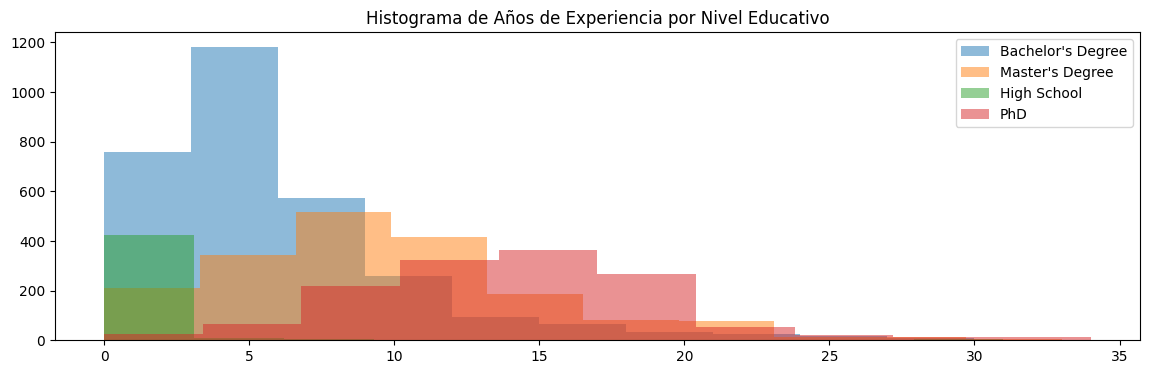

In [91]:

edades_todas = df['Years of Experience'].dropna().values
edades_B = df[df['Education Level']=="Bachelor's Degree"].dropna()['Years of Experience'].values
edades_P = df[df['Education Level']=='PhD'].dropna()['Years of Experience'].values
edades_M = df[df['Education Level']=="Master's Degree"].dropna()['Years of Experience'].values
edades_HS = df[df['Education Level']=='High School'].dropna()['Years of Experience'].values

fig, ax = plt.subplots(figsize=(14, 4), nrows=1, ncols=1)
ax.hist(edades_B, alpha=0.5, label="Bachelor's Degree")
ax.hist(edades_M, alpha=0.5, label="Master's Degree")
ax.hist(edades_HS, alpha=0.5, label='High School')
ax.hist(edades_P, alpha=0.5, label='PhD')
ax.set_title('Histograma de Años de Experiencia por Nivel Educativo')
ax.legend()
plt.show()


La media de los años de experiencia laboral de los ciudadanos de este país se ha estimado en 8 años hasta el año pasado. En concreto, responda las siguientes preguntas:


3. **[13 pts]** Con una significancia del 5%, ¿Existe evidencia suficiente para concluir que los años de experiencia de las personas es menor a lo esperado? Elija una región crítica y explique las ventajas y desventajas de hacerla más grande.

In [92]:
Test_E = contraste_1media(n1 = len(edades_todas),
                        media1 = edades_todas.mean(),
                        std1 = edades_todas.std(),
                        mu0 = 8,
                        error_tipo1 = 0.05,
                        alternativa='1>0')

estadistico, region_critica, p_valor = Test_E
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

El estadístico T0 es 1.2854244522191365
La region crítica es (1.6450811887306331, inf)
El p-valor es 0.0993442248215699


RESPUESTA 3)
> Podemos ver que en el p-valor que H0 puede ser aceptada con una significancia de aproximadamente 9%. Esto quiere decir que si aumentamos la significancia al nivel aceptable del 10% no podremos rechazar H0, por lo que podríamos enfocar nuestro análisis en esa posiblidad. Si bien aumentar el tamaño de la región crítica puede ayudar a aumentar la precisión, también es cierto que si esta es muy pequeña nunca podremos concluir al respecto.

4. **[14.5 pts]** Se dice que para las profesiones más saturadas, la retención laboral de dichos puestos es muy baja, en comparación a aquellas que tienen pocos profesionales desempeñandose en ellas, ya que son personas "irremplazables" en las empresas. Diseñe un contraste para poder determinar si la media de años de experiencia de cierto puesto laboral es menor que el de el puesto laboral con menos trabajadores según los datos. Realice este procedimiento para los 2 empleos con más trabajadores de la muestra. Trabaje con una significancia del 5%. Determine el máximo error tipo I que debiésemos estar dispuestos a aceptar para poder aceptar las hipótesis planteadas.

In [93]:
job_counts = df['Job Title'].value_counts()
top_two = job_counts.nlargest(2).index.tolist()
less_workers = job_counts.idxmin()

print(f"Empleos con más trabajadores: {top_two[0]}, {top_two[1]}")
print("Empleo con menos trabajadores: ", less_workers)

Empleos con más trabajadores: Software Engineer, Data Scientist
Empleo con menos trabajadores:  Director of Sales and Marketing


Notemos que el empleo con menos trabajadores (Director of Sales and Marketing) solo tiene un trabajador.

In [94]:
df_smallest = df.loc[df["Job Title"] == less_workers]
print(f"Numero de trabajadores de {less_workers}: {df_smallest.shape[0]}")

Numero de trabajadores de Director of Sales and Marketing: 1


Esto significa que no podemos usar el sistema para contraste de dos medias, ya que una de las desviaciones estándar es 1. Por esto, haremos un contraste para solo una media y asignaremos el valor de los años de experiencia de Director of Sales and Marketing a $µ_0$.

Primero haremos el contraste de hipótesis para Software Engineer:

In [95]:
df_first_largest = df.loc[df["Job Title"] == top_two[0]]

test_YoE = contraste_1media(n1 = df_first_largest.shape[0],
                media1 = df_first_largest["Years of Experience"].mean(),
                std1 = df_first_largest["Years of Experience"].std(),
                mu0 = df_smallest["Years of Experience"].iloc[0],
                error_tipo1 = 0.05,
                alternativa='1<0')

estadistico, region_critica, p_valor = test_YoE
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

El estadístico T0 es -179.98910631378342
La region crítica es (-inf, -1.64780627653772)
El p-valor es 0.0


Esto significa que podemos rechazar relajadamente la hipótesis nula en favor de la alternativa. Esto es, podemos afirmar que el empleo con menos trabajadores tiene en promedio más años de experiencia que el empleo con más trabajadores.

Ahora realicemos el mismo análisis para el segundo empleo con más trabajadores:

In [96]:
df_second_largest = df.loc[df["Job Title"] == top_two[1]]

test_YoE = contraste_1media(n1 = df_second_largest.shape[0],
                media1 = df_second_largest["Years of Experience"].mean(),
                std1 = df_second_largest["Years of Experience"].std(),
                mu0 = df_smallest["Years of Experience"].iloc[0],
                error_tipo1 = 0.05,
                alternativa='1<0')

estadistico, region_critica, p_valor = test_YoE
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

El estadístico T0 es -42.042050299565915
La region crítica es (-inf, -1.6482317597075216)
El p-valor es 1.3440723355721122e-158


El resultado es similar al del análisis anterior. Rechazamos la hipótesis nula en favor de la alternativa.

5.
Ud. como asesor quiere conocer si es que existe una diferencia importante en cuanto a la varianza salarial en el sector de investigación en la profesión de Data Science entre personas que tienen un Master's Degree y personas con PhD.$\\$
Considerando los datos de la muestra las personas con master's degree tienen una desviación estandar salarial de \$31723 mientras que los quienes tienen PhD tienen una desviación estandar salarial de  \$38590 (considerando sólo la profesión de Data Science) .$\\$ Utilizando un modelo de test de hipótesis pruebe la afirmación "*La varianza salarial de personas con master's Degree es menor respecto a la de personas con PhD para la profesión de Data Scientist*". $\\$
Para esto trabaje con un nivel de significancia del 5%, y responda: $\\$

* a)**[4 pts]** Cuál es el estadístico bajo $H_0$? ¿Qué suposiciones se deben realizar?
* b)**[6 pts]** Confirme o niegue la afirmación del enunciado. Exponga el modelo utilizado y rgumente con región crítica y resultado del estadístico.
* c)**[3.75 pts]** Obtenga e interprete el P-Value para sus resultados. ¿Qué deberíamos modificar del problema para llegar aceptar H0?¿Qué estamos arriesgando al hacer este cambio?




In [97]:
master_degree_std = 31723
phd_std = 38590
df_master_dg = df.loc[(df['Education Level'] == "Master's Degree") & (df["Job Title"] == "Data Scientist")]
df_phd = df.loc[(df['Education Level'] == "PhD") & (df["Job Title"] == "Data Scientist")]

testVar = contraste_dos_varianzas(n_x = df_master_dg["Salary"].shape[0],
                               n_y = df_phd["Salary"].shape[0],
                               std_x = master_degree_std,
                               std_y = phd_std,
                               error_tipo1 = 0.05,
                               alternativa='x<y')

estadistico, region_critica, p_value = testVar
print(f"El estadístico F0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_value}")


El estadístico F0 es 0.6757700581947975
La region crítica es (-inf, 0.7689789741542387)
El p-valor es 0.007384415602365004


RESPUESTA 5.A)
>* Se asume que las muestras son IID
* Se asume que los salarios siguen una distribución normal

RESPUESTA 5.B)

>El estadístico pertenece a la región crítica, por lo que rechazamos H0 y aceptamos H1, concluyendo entonces que la varianza salarial de personas con master's Degree es menor respecto a la de personas con PhD para la profesión de Data Scientist.

RESPUESTA 5.C)

>El p-valor es, aproximadamente, 0.00738, lo que indica que es un valor muy pequeño y, por lo tanto, existe una muy fuerte evidencia en contra de la hipótesis nula, por lo que es muy probable que la varianza salarial de personas con master's Degree sea menor respecto a la de personas con PhD para la profesión de Data Scientist. Además, al ser un p-valor tan pequeño existe una mayor fiabilidad en el resultado del estudio.

6. Ud. como asesor quiere corroborar si es que verdaderamente existe una diferencia entre hombres y mujeres que que se vea reflejada en su salario.
Considerando los datos de la muestra y la categoría 'Salary', construya un modelo de test de hipótesis en el cual pruebe la siguiente afirmación "*La proporción de mujeres con un salario mayor a 70000 es mayor que la proporción de hombres con un salario mayor a 70000*". utilice un nivel de significancia del 0,1% Responda:
* a) **[4 pts]** ¿De qué manera se calcula la proporción de cada grupo? ¿cual es el resultado de la proporción de ambos grupos?. Según el resultado responda la afirmación del enunciado.
* b) **[6 pts]** Confirme o niegue la afirmación del enunciado. Exponga el modelo utilizado. Además argumente con región crítica y resultado del estadístico. Mencione los supuestos para el modelo de test de hipótesis sea correcto.
* c) **[3.75 pts]** En el ministerio tenían los resultados del inciso a), ¿Logró el ministerio concluir información correcta ?(lo que se quiere responder es: ¿independiente del método usado el resultado es el mismo?) Según el inciso b) ¿Qué le comunicaría al ministerio como consultor para que haga en los próximos años?


In [98]:
df_male_70000 = df.loc[(df["Gender"]== "Male") & (df["Salary"] > 70000)]
df_female_70000 = df.loc[(df["Gender"] == "Female") & (df["Salary"] > 70000)]

df_male = df.loc[(df["Gender"] == "Male")]
df_female = df.loc[(df["Gender"] == "Female")]

prop_male = df_male_70000.shape[0] / df_male.shape[0]
prop_female = df_female_70000.shape[0] / df_female.shape[0]

testMaleFemaleProps = contraste_2props(n_x = df_male_70000.shape[0],
                        n_y = df_female_70000.shape[0],
                        prop_x = prop_male,
                        prop_y = prop_female,
                        error_tipo1 = 0.001,
                        alternativa='x<y')

estadistico, region_critica, p_value = testMaleFemaleProps
print(f"La proporción de hombres es {prop_male:.4f}")
print(f"La proporción de mujeres es {prop_female:.4f}")
print(f"El estadístico Z0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_value}")



La proporción de hombres es 0.7695
La proporción de mujeres es 0.6751
El estadístico Z0 es 7.317511014593808
La region crítica es (-inf, -3.090232306167813)
El p-valor es 0.9999999999998737



RESPUESTA 6.A)
> La proporción de hombres se calcula en el total de hombres con salario mayor a $70.000 dividido en el total de hombres, se hace el proceso análogo para la proporción de mujeres.

> Luego, el resultado de la proporción de hombres es, aproximadamente, 0.7695, y el resultado de la proporción de mujeres es, aproximadamente, 0.6751.

> En base a la afirmación del enunciado "La proporción de mujeres con un salario mayor a 70000 es mayor que la proporción de hombres con un salario mayor a 70000", podemos observar que la proporción de hombres experimental es mayor que la proporción de mujeres experimental.

RESPUESTA 6.B)
> Tomando un supuesto de que la muestra es IID y bajo el supuesto de normalidad, el estadístico Z0 no pertenece a la región crítica, por lo que aceptamos H0 y rechazamos H1, formalmente, se concluye que no hay información suficiente para rechazar H0, por lo que, implicitamente significa aceptarla.
Por lo tanto la afirmación del enunciado es falsa. Como extra, el p-valor es prácticamente 1, lo que indica que hay una muy fuerte evidencia de que H0 es verdadero.

RESPUESTA 6.C)
>  El ministerio concluyó la información correcta, independiente del método usado el resultado es el mismo, ya que el p-valor es 1, por lo que siempre se acepta H0. Luego, como consultor, para aumentar la fiabilidad del estudio, recomendaría calcular las proporciones considerando años de experiencia y nivel de educación (Master Degree, PhD...)  para analizar si ocurre para todo nivel de educación que la proporción de hombres es mayor que la proporción de mujeres (ambos con salarios mayor a $70.000), o si esto depende de los años de experiencia, ya que esto puede ocurrir por muchas razones.

7. **[15 pts]** Considere la nueva columna "Job Sector" que agrupa a los trabajos según su sector laboral, en especifico la agrupación STEM definida a continuación. Determine, utilizando regresión lineal si la experiencia de trabajo es un mejor predictor **válido** para el salario de hombres o mujeres trabajando en STEM. Por ahora basta con realizar el test de hipótesis correspondiente, con un 95% de confianza, para determinar la validez del predictor. Se deben indicar tanto la hipótesis nula como la alternativa. Le pueden resultar útiles los ***links útiles*** (en especial los primeros dos) para formular su conclusión.

In [99]:
sectors = {
    "Technology and Engineering": ['Software Engineer', 'Software Developer', 'Senior Engineer', 'Software Engineer Manager',
                                   'IT Support', 'Junior Developer', 'Project Engineer', 'Network Engineer'],
    "Web Development": ['Web Developer', 'Front-End Developer',
                                      'Full Stack Engineer', 'Back end Developer', 'UX Designer', 'UX Researcher'],
    "Data Science and Analytics": ['Data Analyst', 'Data Scientist', 'Business Intelligence Analyst',
                                    'Senior Data Scientist'],
    "Management, Consulting, and Finance": ['Senior Manager', 'Director', 'Product Manager',
                                            'Financial Analyst', 'Project Manager', 'Operations Manager',
                                            'Business Analyst', 'VP of Operations', 'Financial Manager',
                                            'Senior Consultant', 'CEO', 'Accountant', 'Strategy Consultant',
                                            'Research Director', 'Senior Project Engineer', 'VP of Finance'],
    "Marketing, Sales, and HR": ['Sales Associate', 'Marketing Analyst', 'Sales Manager',
                                 'Marketing Coordinator', 'HR Manager', 'Marketing Manager', 'Sales Director',
                                 'Recruiter', 'Social Media Specialist', 'Marketing Specialist', 'HR Generalist',
                                 'Sales Executive', 'Marketing Director', 'Content Marketing Manager',
                                 'Junior HR Generalist', 'Senior Product Marketing Manager', 'Director of HR',
                                 'Junior Sales Associate']
}

df['Job Sector'] = df['Job Title'].apply(lambda title: next((sector for sector, titles in sectors.items() if title in titles), "Others"))
df['Job Sector'].value_counts()

Marketing, Sales, and HR               1449
Others                                 1407
Management, Consulting, and Finance    1026
Technology and Engineering             1025
Web Development                         913
Data Science and Analytics              878
Name: Job Sector, dtype: int64

In [100]:
df_stem = df[df["Job Sector"].isin(["Technology and Engineering", "Web Development", "Data Science and Analytics"])]

In [101]:
x_values = df_stem["Years of Experience"].to_numpy().reshape(-1,1)
y_values = df_stem["Salary"].to_numpy()

reg = LinearRegression()
reg.fit(x_values, y_values)

LinearRegression()

Primero, comprobamos la linealidad entre predictores y resultados:

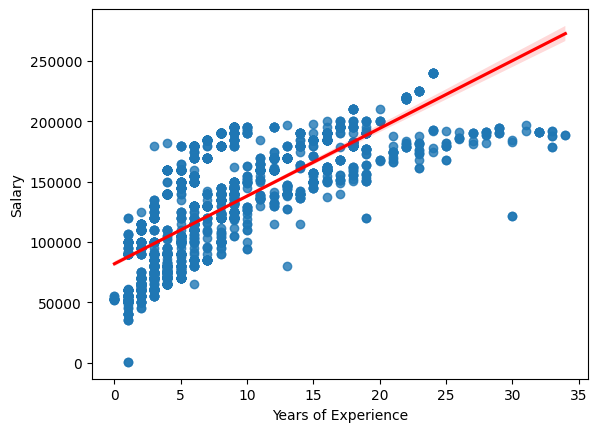

In [102]:
sns.regplot(x='Years of Experience', y='Salary', data=df_stem, line_kws={"color": "red"})
plt.show()

Luego, comprobamos la normalidad de los residuos:

<ipython-input-103-722ff7fba6f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stem['Predicted'] = reg.predict(x_values)
<ipython-input-103-722ff7fba6f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stem['Residuals'] = df_stem['Salary'] - df_stem['Predicted']


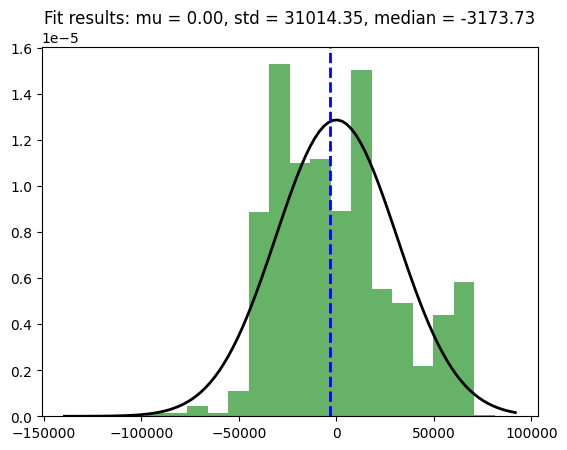

In [103]:
df_stem['Predicted'] = reg.predict(x_values)

df_stem['Residuals'] = df_stem['Salary'] - df_stem['Predicted']

plt.hist(df_stem['Residuals'], bins=20, density=True, alpha=0.6, color='g')

mu = df_stem["Residuals"].mean()
std = df_stem["Residuals"].std()
med = df_stem['Residuals'].median()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.axvline(med, color='blue', linestyle='dashed', linewidth=2)

title = f"Fit results: mu = {mu:.2f}, std = {std:.2f}, median = {med:.2f}"
plt.title(title)

plt.show()

Los datos no se distribuyen exactamente normales, pero el resultado es cercano.

Ahora comprobamos la independencia de los residuos y la heteroscedasticidad:

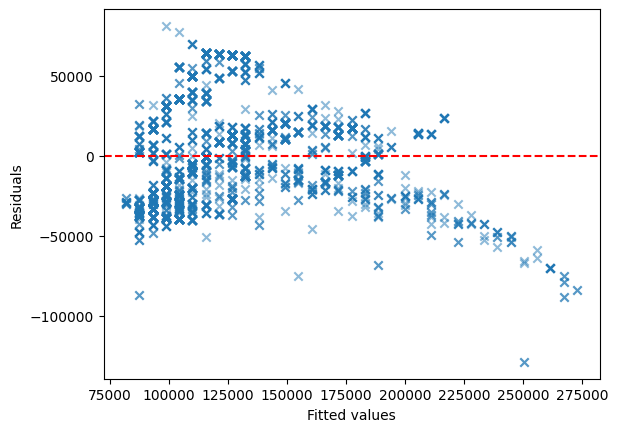

In [104]:
plt.scatter(df_stem['Predicted'], df_stem['Residuals'], marker = "x", alpha = 0.5)

plt.axhline(y=0, color='r',
            linestyle='--')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Podemos ver que para un valor alrededor de 212500 los requisitos para la validez del modelo no se cumplen.

Realizaremos el siguiente test de hipótesis para testear la validez del predictor:

In [105]:
print(reg.score(x_values,y_values))
print(p_value_analysis(x_values, y_values, reg, 0.05))

0.5543247998309393
F-statistic: 3500.0152266326418
p-value: 1.1102230246251565e-16
True


El predictor no es válido.